# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'C:\\datasets\\C-FAR\\cifar-10-batches-py'
  #cifar10_dir = 'C:\\datasets\\C-FAR\\cifar-10-batches-py'

  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('dev data shape: ', X_dev.shape)
print ('dev labels shape: ', y_dev.shape)

Loading CIFAR10 Data from dir: C:\datasets\C-FAR\cifar-10-batches-py
Done Load.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [7]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('loss: %f' % loss)
print ('sanity check: %f' % (-np.log(0.1)))

loss: 2.408057
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*
There are 10 classes so we by chance should get about 1/10 samples correct by luck. This Loss function is the log probability of correct answers.

In [16]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.068874 analytic: 1.068874, relative error: 2.639640e-09
numerical: -0.012929 analytic: -0.012928, relative error: 9.995423e-07
numerical: 0.501857 analytic: 0.501857, relative error: 8.550471e-08
numerical: -1.213222 analytic: -1.213222, relative error: 9.965326e-09
numerical: 0.687383 analytic: 0.687383, relative error: 9.886568e-08
numerical: 1.190201 analytic: 1.190200, relative error: 1.896651e-08
numerical: 1.240843 analytic: 1.240843, relative error: 2.075437e-08
numerical: -0.536207 analytic: -0.536207, relative error: 4.215944e-08
numerical: -1.019973 analytic: -1.019973, relative error: 4.518344e-09
numerical: 2.788705 analytic: 2.788705, relative error: 2.728448e-08
numerical: -4.995029 analytic: -4.995029, relative error: 6.830140e-09
numerical: -0.790535 analytic: -0.790535, relative error: 1.665799e-08
numerical: -0.250906 analytic: -0.250906, relative error: 2.106100e-08
numerical: 1.806427 analytic: 1.806427, relative error: 2.373852e-08
numerical: -0.828185

In [21]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print ('Gradient difference: %f' % grad_difference)

naive loss: 2.408057e+00 computed in 0.437371s
scores shape: (500, 10)
sum shape (500,)
mask shape (500, 10)
vectorized loss: 2.408057e+00 computed in 0.013009s
Loss difference: 0.000000
Gradient difference: 0.000000


In [25]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-5,1e-6,1e-7,1e-8]
regularization_strengths = [1e4, 1e3,1e2,1,1e5]

################################################################################
# VALIDATION:                                                                        #


# Step through learning rate and reg. strengths
for lr in learning_rates:
    for rs in regularization_strengths:
        print('*************************************')
        print('training rs = %f lr = %0.11f" %(rs,lr))
        # train the model
        sm = Softmax()
        sm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=2000, verbose=False)
        
        # get validation predictions & training predictions
        val_predict = sm.predict(X_val)
        train_predict = sm.predict(X_train)
        val_acc = np.mean(val_predict == y_val)
        train_acc = np.mean(train_predict == y_train)
        
        print('train accuracy = %f val accuracy = %f' % (train_acc,val_acc))
        # add the set to dictionary
        results[(lr,rs)] = (train_acc,val_acc)
        
        # check if best and if so store
        if (val_acc > best_val):
            best_softmax = sm
            best_val = val_acc
            
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

train accuracy = 0.201429 val accuracy = 0.196000
train accuracy = 0.241082 val accuracy = 0.255000
train accuracy = 0.348184 val accuracy = 0.351000
train accuracy = 0.321408 val accuracy = 0.304000
train accuracy = 0.120735 val accuracy = 0.129000
train accuracy = 0.364388 val accuracy = 0.363000
train accuracy = 0.407755 val accuracy = 0.414000
train accuracy = 0.372122 val accuracy = 0.343000
train accuracy = 0.362449 val accuracy = 0.374000
train accuracy = 0.305347 val accuracy = 0.317000
train accuracy = 0.360796 val accuracy = 0.381000
train accuracy = 0.270224 val accuracy = 0.285000
train accuracy = 0.264612 val accuracy = 0.277000
train accuracy = 0.257571 val accuracy = 0.241000
train accuracy = 0.299061 val accuracy = 0.327000
train accuracy = 0.155694 val accuracy = 0.166000
train accuracy = 0.182918 val accuracy = 0.163000
train accuracy = 0.159469 val accuracy = 0.150000
train accuracy = 0.151041 val accuracy = 0.152000
train accuracy = 0.247735 val accuracy = 0.261000


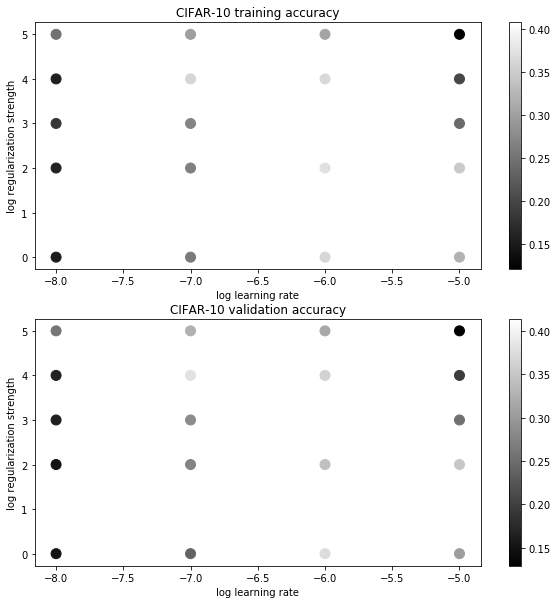

In [26]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

plt.figure(figsize = (10,10))
# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [28]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.377000


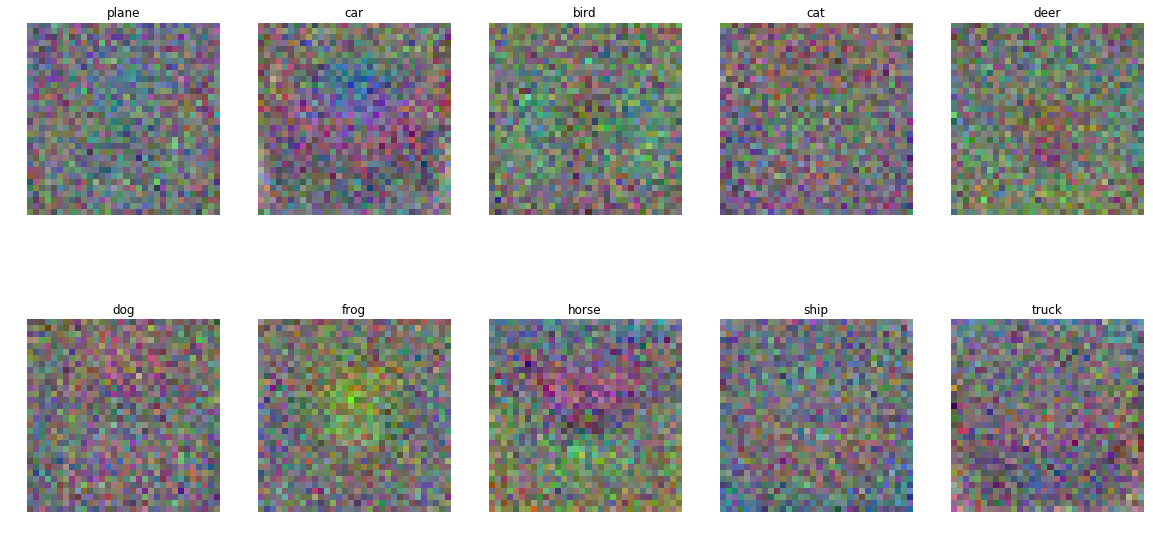

In [34]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize = (20,10))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])